# IMPORTS

In [1]:
import ohsome
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import datetime
import shapely

import json

from pathlib import Path
from time import sleep

# MISC.

In [2]:
tex_fonts = {
        "text.usetex": True,
        "font.family": "serif",
        "axes.titlesize": 10, 
        "axes.labelsize": 10,
        "font.size": 10,
        "legend.fontsize": 'xx-small',
        "legend.title_fontsize": 10,
        "xtick.labelsize": 8, #'xx-small',
        "ytick.labelsize": 8, #'xx-small',
        "ps.usedistiller": "xpdf"
        }
plt.rcParams.update(tex_fonts)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath,amssymb,underscore}'

In [3]:
cm=1/2.54

In [4]:
path_geo = Path('/home/lemasle/GEO/test_geospatial')
path_plots = Path('/home/lemasle/GEO/test_geospatial/plots')
path_data = Path('/home/lemasle/GEO/test_geospatial/data')

# CLIENT

In [5]:
client = ohsome.OhsomeClient()

# FILTERS

In [6]:
# Certainly room for improvement in the definition of these filters

In [7]:
solar = "(power=plant and plant:source=solar) or (power=generator and generator:source=solar)"
roads = "type:way and (highway in (motorway, motorway_link, trunk, trunk_link, primary, primary_link, secondary, secondary_link, tertiary, tertiary_link, unclassified, residential, living_street) or (highway=service and service=alley))"
bike_path = "type:way and ((sidewalk:left:bicycle=yes) or (cycleway:left=shared_lane) or (cyclestreet=yes) or (cycleway:left=shared_busway) or (cycleway:right=shared_busway) or (cycleway=shared_busway) or (cycleway=opposite_lane) or (highway=bridleway and bicycle=no) or (highway=track and bicycle=designated and motor_vehicle=no) or (bicycle=use_sidepath) or (cycleway=opposite and oneway:bicycle=no) or (sidewalk:right:bicycle=yes) or (cycleway:right=shared_lane) or (cycleway:left=track) or  (cycleway:right=track) or (highway=track and bicycle=designated and motor_vehicle=no) or (highway=path and bicycle=yes) or (highway=path and (bicycle=designated or bicycle=official)) or (highway=service and (bicycle=designated or motor_vehicle=no)) or (highway=pedestrian and (bicycle=yes or bicycle=official)) or (highway=footway and (bicycle=yes or bicycle=official)) or (highway=cycleway) or (cycleway in (lane, opposite_lane, shared_busway, track, opposite_track)) or (cycleway:left in (lane, shared_busway)) or (cycleway:right in (lane, shared_busway)) or (cycleway:both=lane) or (bicycle_road=yes and (motor_vehicle=no or bicycle=designated)) or (cyclestreet=yes))"

# QUERIES

In [8]:
# Very rough description of Heidelberg as square box
bboxes_HD = [8.6581,49.3836,8.7225,49.4363]

# Time interval in which data is queried
time = "2010-03-01T13:00:00Z/2023-07-01T15:30:00Z/P1M"

# FUNCTIONS

Getting the error message below when converting response to df.
Probably a wrong combination of package versions or conflicting installation source (pip/conda) 

ValueError: unconverted data remains when parsing with format "%Y-%m-%dT%H:%M:%S": "Z", at position 0. You might want to try:
- passing `format` if your strings have a consistent format;
- passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
- passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [9]:
# This function is a workaround to retrieve data in dataframes via json files since as_dataframe() conversion returns an error

def retrieve_df(region, reg_type, time, filter, endpoint):

    if endpoint == 'count': 
        end = "elements/count"
    elif endpoint == 'length':
        end = "elements/length"
    else:
        print('Invalid endpoint')

    if reg_type == 'bboxes': 
        query = client.post(bboxes=region, time=time, filter=filter, endpoint=end)
    elif reg_type == 'bcircles':
        query = client.post(bcircles=region, time=time, filter=filter, endpoint=end)
    elif reg_type == 'bpolys':
        query = client.post(bpolys=region, time=time, filter=filter, endpoint=end)
    else:
        print('Invalid region type')
    # without specifying the region type:
    # query = client.post(region, time=time, filter=filter, endpoint=end)
    
    query.to_json("./query.json")
    temp = json.load(open("./query.json"))
    
    df = pd.DataFrame(temp["result"])
    # convert timestamp to datetime format and keep only the date
    df['timestamp']= pd.to_datetime(df['timestamp']).dt.date
    
    return df

In [10]:
def round_to_multiple(number, multiple, direction='nearest'):

    from math import ceil, floor
    
    if direction == 'nearest':
        return multiple * round(number / multiple)
    elif direction == 'up':
        return multiple * ceil(number / multiple)
    elif direction == 'down':
        return multiple * floor(number / multiple)
    else:
        return multiple * round(number / multiple)

# BIKEPATHS

In [11]:
HD_bike_count = retrieve_df(bboxes_HD, 'bboxes', time, bike_path, 'count')
sleep(5)
HD_bike_length = retrieve_df(bboxes_HD, 'bboxes', time, bike_path, 'length')

In [12]:
HD_bike_count.rename(columns={'value': 'bikepath_count'}, inplace=True)
HD_bike_length.rename(columns={'value': 'bikepath_length'}, inplace=True)
HD_bike_length.head()

,timestamp,bikepath_length
0,2010-03-01,55590.53
1,2010-04-01,55424.66
2,2010-05-01,55482.25
3,2010-06-01,55804.73
4,2010-07-01,56606.16


In [13]:
HD_road_length = retrieve_df(bboxes_HD, 'bboxes', time, 'highway=*', 'length')
HD_road_length.rename(columns={'value': 'road_length'}, inplace=True)
HD_road_length

,timestamp,road_length
0,2010-03-01,483153.53
1,2010-04-01,485253.51
2,2010-05-01,486031.80
3,2010-06-01,486732.82
4,2010-07-01,487819.14
...,...,...
156,2023-03-01,696925.87
157,2023-04-01,697184.53
158,2023-05-01,697586.71
159,2023-06-01,697863.78


In [14]:
HD = HD_bike_length.merge(HD_road_length, left_on='timestamp', right_on='timestamp')
HD['bike_road_length_ratio']= HD.bikepath_length/HD.road_length*100

In [15]:
def plot_bikepath_HD(df, path, filename, cm):

    from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

    fig = plt.figure(figsize=(14*cm, 10*cm))
    ax_ratio = fig.add_subplot(111)

    df['timestamp']= pd.to_datetime(df['timestamp'])
    ax_ratio.plot(df.timestamp, df.bike_road_length_ratio, c='Dodgerblue', lw=2)    

    ymin = round_to_multiple(df.bike_road_length_ratio.min(), 5, direction='down')
    ymax = round_to_multiple(df.bike_road_length_ratio.max(), 5, direction='up')

    ax_ratio.set(
        title=r"Evolution of the ratio of bike paths vs normal roads in Heidelberg",
        xlabel=r"Time [yr]",
        ylabel=r"Ratio of bike paths vs normal roads [\%]",
        ylim=[ymin-3, ymax],
        )
    
    # insert plot showing the individual time5 evolution of bikepaths & roads
    axins = ax_ratio.inset_axes([0.45, 0.15, 0.5, 0.4]) #[x0, y0, width, height]
    axins.plot(df['timestamp'], df['bikepath_length']/1000, c='blue', lw=1, label='bikepaths')
    axins.plot(df['timestamp'], df['road_length']/1000, c='navy', lw=1, label='roads')

    ymin_axins = round_to_multiple(df.bikepath_length.min()/1000, 100, direction='down')
    ymax_axins = round_to_multiple(df.road_length.max()/1000, 100, direction='up')
    
    axins.set(
        title=r"Evolution of the network length",
        xlabel=r"Time [yr]",
        ylabel=r"Network length [km]",
        ylim=[ymin_axins, ymax_axins],
    )
    axins.legend(loc='center right')
    
    file = path / str(filename)
    fig.savefig(file, format='pdf')

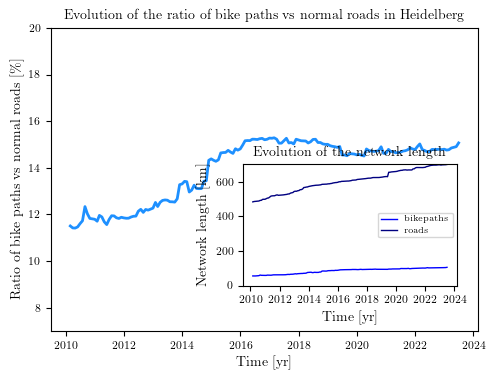

In [16]:
plot_bikepath_HD(HD, path_plots, 'Bike_path_HD.pdf', cm)

# Solar Energy

In [17]:
HD_solar_count = retrieve_df(bboxes_HD, 'bboxes', time, solar, 'count')
HD_solar_count.rename(columns={'value': 'solar_count'}, inplace=True)
HD_solar_count.head()

,timestamp,solar_count
0,2010-03-01,0.0
1,2010-04-01,0.0
2,2010-05-01,0.0
3,2010-06-01,0.0
4,2010-07-01,0.0


In [18]:
def plot_solar_HD(df, path, filename, cm):

    fig = plt.figure(figsize=(14*cm, 10*cm))
    ax_solar = fig.add_subplot(111)

    df['timestamp']= pd.to_datetime(df['timestamp'])
    ax_solar.plot(df.timestamp, df.solar_count, c='Dodgerblue', lw=2, label = 'Reported Solar energy sources')    
    
    ax_solar.set(
        title=r"Evolution of the number of Solar energy sources in Heidelberg",
        xlabel=r"Time [yr]",
        ylabel=r"Number of objects",
        ylim=[8, 250],
        )
    ax_solar.legend(loc='upper left')  
    
    file = path / str(filename)
    fig.savefig(file, format='pdf')

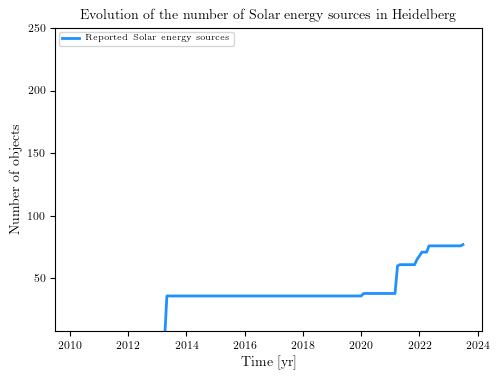

In [19]:
plot_solar_HD(HD_solar_count, path_plots, 'Solar_count_HD.pdf', cm)

In [20]:
# Using the real borders Heidelberg

In [21]:
new_coords = gpd.read_file(path_data / 'Heidelberg.geojson')
new_coords

,City,geometry
0,Heidelberg,"POLYGON ((8.67219 49.36059, 8.67190 49.35919, ..."


In [22]:
# get the geometry
new_coords_geom = new_coords.geometry
print('Geometry:\n', new_coords_geom)
# get the geometry in json format
print('Geometry as json:\n', new_coords_geom.to_json)
# get coordinates
new_coords_coords = new_coords.geometry.get_coordinates()
print('Coordinates:\n', new_coords_coords.head())

Geometry:
 0    POLYGON ((8.67219 49.36059, 8.67190 49.35919, ...
Name: geometry, dtype: geometry
Geometry as json:
 <bound method GeoSeries.to_json of 0    POLYGON ((8.67219 49.36059, 8.67190 49.35919, ...
Name: geometry, dtype: geometry>
Coordinates:
          x         y
0  8.67219  49.36059
0  8.67190  49.35919
0  8.67168  49.35782
0  8.67146  49.35780
0  8.66876  49.35813


In [23]:
example = retrieve_df(region=new_coords, reg_type='bpolys', time=time, filter=roads, endpoint='length')
example

,timestamp,value
0,2010-03-01,498817.39
1,2010-04-01,499022.52
2,2010-05-01,499708.66
3,2010-06-01,499224.13
4,2010-07-01,499594.61
...,...,...
156,2023-03-01,534047.44
157,2023-04-01,532793.63
158,2023-05-01,531758.97
159,2023-06-01,531762.77


In [24]:
HD_bike_length = retrieve_df(new_coords, 'bpolys', time, bike_path, 'length')
HD_bike_count.rename(columns={'value': 'bikepath_count'}, inplace=True)
HD_bike_length.rename(columns={'value': 'bikepath_length'}, inplace=True)
HD_bike_length.head()

,timestamp,bikepath_length
0,2010-03-01,89303.32
1,2010-04-01,89996.33
2,2010-05-01,88838.30
3,2010-06-01,87321.71
4,2010-07-01,88963.92


In [25]:
HD_road_length = retrieve_df(new_coords, 'bpolys', time, 'highway=*', 'length')
HD_road_length.rename(columns={'value': 'road_length'}, inplace=True)
HD_road_length

,timestamp,road_length
0,2010-03-01,1436075.57
1,2010-04-01,1448184.03
2,2010-05-01,1452985.93
3,2010-06-01,1452528.34
4,2010-07-01,1475050.11
...,...,...
156,2023-03-01,1947634.64
157,2023-04-01,1947146.30
158,2023-05-01,1948151.13
159,2023-06-01,1948803.49


In [26]:
HD = HD_bike_length.merge(HD_road_length, left_on='timestamp', right_on='timestamp')
HD['bike_road_length_ratio']= HD.bikepath_length/HD.road_length*100

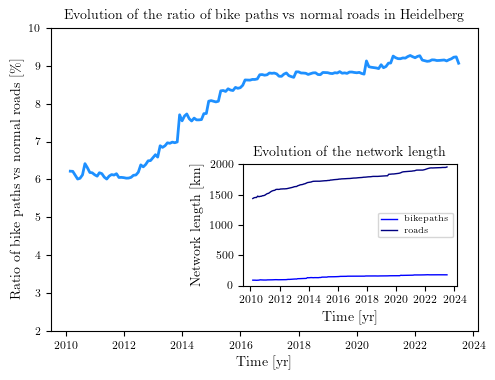

In [27]:
plot_bikepath_HD(HD, path_plots, 'Bike_path_HD.pdf', cm)

In [28]:
HD_solar_count = retrieve_df(new_coords, 'bpolys', time, solar, 'count')
HD_solar_count.rename(columns={'value': 'solar_count'}, inplace=True)
HD_solar_count.head()

,timestamp,solar_count
0,2010-03-01,0.0
1,2010-04-01,0.0
2,2010-05-01,0.0
3,2010-06-01,0.0
4,2010-07-01,0.0


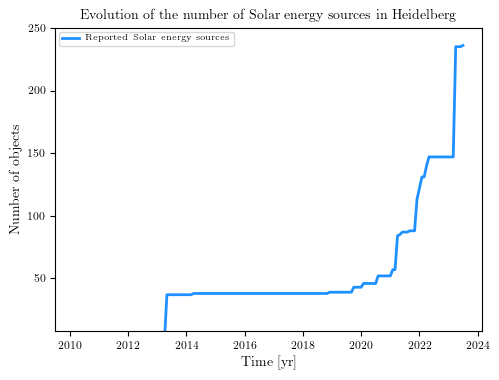

In [29]:
plot_solar_HD(HD_solar_count, path_plots, 'Solar_count_HD.pdf', cm)